In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

sns.set(context="paper", style="whitegrid", 
       rc={
           "figure.figsize": (8, 5),
           "figure.dpi": 100
       })
google = ["#4285F4", "#DB4437", "#F4B400", "#0F9D58"]

sns.set_palette(google)

from preprocess_lib import preprocess_df, preprocess_timeseries

seed_ = 20200218
np.random.seed(seed_)

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Lambda, Conv1D
from keras.optimizers import *
tf.random.set_seed(seed_)
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Idea

- forecast main meter `active power` from previous data

## Problem

- เหมือนมันทำ regression
- คาดว่าเพราะข้อมูลไม่ได้มี period ที่แน่นอน?
- หรือเพราะข้อมูลที่เป็น step? อยู่ๆก็พุ่งขึ้น?

#### constant

number of minute in one day and one week

In [2]:
ONEDAY_MIN = 24*60
ONEWEEK_MIN = ONEDAY_MIN*7

In [3]:
ONEDAY_MIN, ONEWEEK_MIN

(1440, 10080)

## Load Meter Data

### explore the dataframe

In [4]:
df = pd.read_csv("./data/raw_appliances/main_1.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   TIMESTAMP              1051200 non-null  object 
 1   power factor_apparent  1051200 non-null  float64
 2   power_reactive         1051200 non-null  float64
 3   power_active           1051200 non-null  float64
 4   power_apparent         1051200 non-null  float64
 5   appliances_type        1051200 non-null  object 
 6   appliances_id          1051200 non-null  int64  
 7   appliances_name        1051200 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 64.2+ MB


In [6]:
df.head()

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_type,appliances_id,appliances_name
0,2012-04-01 00:00:00,0.93,141.0,918.0,1066.0,main,1,main 1
1,2012-04-01 00:01:00,0.93,141.0,913.0,1056.0,main,1,main 1
2,2012-04-01 00:02:00,0.93,139.0,872.0,1021.0,main,1,main 1
3,2012-04-01 00:03:00,0.93,141.0,872.0,1018.0,main,1,main 1
4,2012-04-01 00:04:00,0.89,140.0,772.0,1018.0,main,1,main 1


#### column variable

In [7]:
timestamp_col = "TIMESTAMP"

### Preprocess data frame

#### convert timestamp to datetime obj

In [8]:
preprocess_df.col_to_datetime(df, timestamp_col)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   TIMESTAMP              1051200 non-null  datetime64[ns]
 1   power factor_apparent  1051200 non-null  float64       
 2   power_reactive         1051200 non-null  float64       
 3   power_active           1051200 non-null  float64       
 4   power_apparent         1051200 non-null  float64       
 5   appliances_type        1051200 non-null  object        
 6   appliances_id          1051200 non-null  int64         
 7   appliances_name        1051200 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 64.2+ MB


#### add some new columns

In [10]:
preprocess_df.add_weekday_col(df, timestamp_col)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   TIMESTAMP              1051200 non-null  datetime64[ns]
 1   power factor_apparent  1051200 non-null  float64       
 2   power_reactive         1051200 non-null  float64       
 3   power_active           1051200 non-null  float64       
 4   power_apparent         1051200 non-null  float64       
 5   appliances_type        1051200 non-null  object        
 6   appliances_id          1051200 non-null  int64         
 7   appliances_name        1051200 non-null  object        
 8   weekday                1051200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 72.2+ MB


### Dataset info

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   TIMESTAMP              1051200 non-null  datetime64[ns]
 1   power factor_apparent  1051200 non-null  float64       
 2   power_reactive         1051200 non-null  float64       
 3   power_active           1051200 non-null  float64       
 4   power_apparent         1051200 non-null  float64       
 5   appliances_type        1051200 non-null  object        
 6   appliances_id          1051200 non-null  int64         
 7   appliances_name        1051200 non-null  object        
 8   weekday                1051200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 72.2+ MB


In [13]:
df.shape

(1051200, 9)

In [14]:
sampling_preriod = preprocess_df.get_sampling_period(df[timestamp_col])
sampling_preriod

sampling period: 0 days 00:01:00
sampling period: 60.0 sec


60.0

### resample data

In [15]:
resampling_period = int(sampling_preriod*1)

df.index = df[timestamp_col]
df = df.resample(f"{resampling_period}s").mean()
df = df.reset_index()

In [16]:
df

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_id,weekday
0,2012-04-01 00:00:00,0.93,141.0,918.0,1066.0,1,6
1,2012-04-01 00:01:00,0.93,141.0,913.0,1056.0,1,6
2,2012-04-01 00:02:00,0.93,139.0,872.0,1021.0,1,6
3,2012-04-01 00:03:00,0.93,141.0,872.0,1018.0,1,6
4,2012-04-01 00:04:00,0.89,140.0,772.0,1018.0,1,6
...,...,...,...,...,...,...,...
1051195,2014-03-31 23:55:00,0.85,169.0,534.0,766.0,1,0
1051196,2014-03-31 23:56:00,0.84,168.0,520.0,757.0,1,0
1051197,2014-03-31 23:57:00,0.83,168.0,525.0,766.0,1,0
1051198,2014-03-31 23:58:00,0.83,163.0,530.0,771.0,1,0


### choose weekday

In [17]:
weekday = 3

df = df[df['weekday'] == weekday]

In [18]:
df.head()

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_id,weekday
5760,2012-04-05 00:00:00,0.82,110.0,484.0,706.0,1,3
5761,2012-04-05 00:01:00,0.82,105.0,479.0,702.0,1,3
5762,2012-04-05 00:02:00,0.88,168.0,621.0,866.0,1,3
5763,2012-04-05 00:03:00,0.87,164.0,616.0,864.0,1,3
5764,2012-04-05 00:04:00,0.87,162.0,603.0,843.0,1,3


### visualize data

In [19]:
power_variable = "power_active"

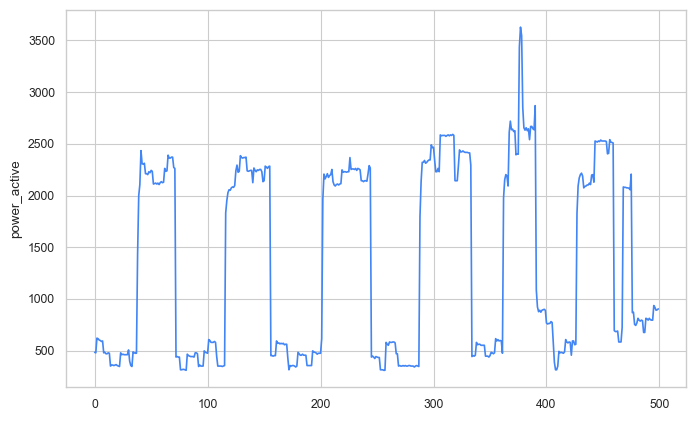

In [20]:
n = 500
sns.lineplot(x=np.arange(len(df[power_variable][:n])), y=df[power_variable][:n])

## 
# Model

## Preprocess

### split train/validation

In [21]:
val_day = 10
oneday_sample = (ONEDAY_MIN*60)//resampling_period

split_index = df.shape[0] - (oneday_sample*val_day)

In [22]:
train = df[:split_index]
val = df[split_index:]

In [23]:
train.head()

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_id,weekday
5760,2012-04-05 00:00:00,0.82,110.0,484.0,706.0,1,3
5761,2012-04-05 00:01:00,0.82,105.0,479.0,702.0,1,3
5762,2012-04-05 00:02:00,0.88,168.0,621.0,866.0,1,3
5763,2012-04-05 00:03:00,0.87,164.0,616.0,864.0,1,3
5764,2012-04-05 00:04:00,0.87,162.0,603.0,843.0,1,3


In [24]:
val.head()

,TIMESTAMP,power factor_apparent,power_reactive,power_active,power_apparent,appliances_id,weekday
953280,2014-01-23 00:00:00,0.96,182.0,1494.0,1670.0,1,3
953281,2014-01-23 00:01:00,0.96,182.0,1498.0,1671.0,1,3
953282,2014-01-23 00:02:00,0.95,187.0,1302.0,1478.0,1,3
953283,2014-01-23 00:03:00,0.96,178.0,1293.0,1462.0,1,3
953284,2014-01-23 00:04:00,0.94,182.0,1211.0,1418.0,1,3


In [25]:
train.shape, val.shape

((135360, 7), (14400, 7))

### preprocess time series data

In [26]:
power_variable = "power_active"

window_size = oneday_sample//24
output_size = 1

In [27]:
window_size

60

In [28]:
X_train, Y_train = preprocess_timeseries.windowing_arr_X_Y(train[power_variable], 
                                                           window_size, output_size)

In [29]:
X_val, Y_val = preprocess_timeseries.windowing_arr_X_Y(val[power_variable], 
                                                           window_size, output_size)

In [30]:
X_train.shape, Y_train.shape

((135300, 60), (135300, 1))

In [31]:
X_val.shape, Y_val.shape

((14340, 60), (14340, 1))

#### reshape for LSTM

In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)

In [33]:
X_train.shape, X_val.shape

((135300, 60, 1), (14340, 60, 1))

## create model

In [34]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, n_epoch):
        self.n_epoch = n_epoch
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == 0 or (epoch+1)%self.n_epoch == 0:
            print(f"Epoch: {epoch+1}")
            for key, value in logs.items():
                print(f"{key}: {value:.4f}", end=" \t ")
            print()

In [35]:
model = Sequential()
model.add(LSTM(1, input_shape=(window_size, 1), return_sequences=False))
model.add(Dense(output_size))

In [36]:
optimizer = Adam(learning_rate=5e-3)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [37]:
num_epochs = 10
batch_size = 16
hist = model.fit(X_train, Y_train, 
                 epochs=num_epochs, batch_size=batch_size, 
                 validation_data=(X_val, Y_val), verbose=1)

Epoch 1/10
8457/8457 [==============================] - 36s 4ms/step - loss: 1069.8950 - val_loss: 981.7765
Epoch 2/10
8457/8457 [==============================] - 36s 4ms/step - loss: 985.3248 - val_loss: 897.2371
Epoch 3/10
8457/8457 [==============================] - 36s 4ms/step - loss: 900.7919 - val_loss: 812.7005
Epoch 4/10
8457/8457 [==============================] - 35s 4ms/step - loss: 816.2557 - val_loss: 728.1740
Epoch 5/10
8457/8457 [==============================] - 38s 4ms/step - loss: 733.3633 - val_loss: 649.3046
Epoch 6/10
8457/8457 [==============================] - 38s 4ms/step - loss: 662.2841 - val_loss: 586.5542
Epoch 7/10
8457/8457 [==============================] - 37s 4ms/step - loss: 607.9990 - val_loss: 547.6366
Epoch 8/10
8457/8457 [==============================] - 33s 4ms/step - loss: 576.3282 - val_loss: 524.7723
Epoch 9/10
8457/8457 [==============================] - 35s 4ms/step - loss: 560.3305 - val_loss: 516.6522
Epoch 10/10
8457/8457 [=============

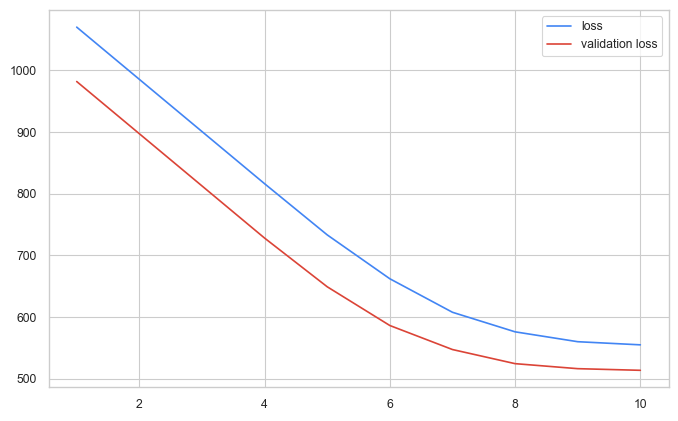

In [38]:
epochs = np.arange(1, num_epochs+1)

sns.lineplot(epochs, hist.history['loss'], label="loss")
sns.lineplot(epochs, hist.history['val_loss'], label="validation loss")

In [39]:
model.predict(np.array([X_val[0]]))

array([[719.3785]], dtype=float32)

In [40]:
Y_val[0]

array([776.])

## Predict Validation set

In [41]:
predicted = model.predict(X_val)

In [42]:
time_x = np.arange(len(Y_val))

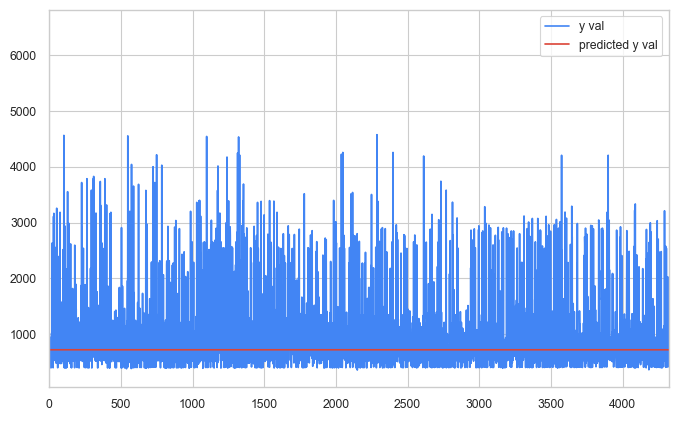

In [43]:
sns.lineplot(time_x, Y_val.squeeze(), label="y val")
sns.lineplot(time_x, predicted.squeeze(), label="predicted y val")


plt.xlim([-5, oneday_sample*3])
plt.show()

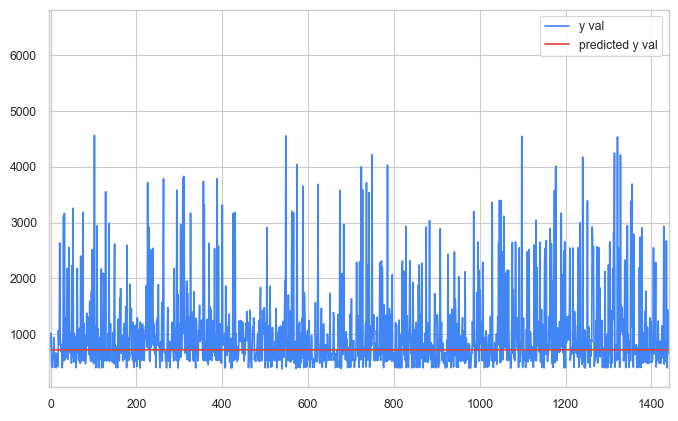

In [44]:
sns.lineplot(time_x, Y_val.squeeze(), label="y val")
sns.lineplot(time_x, predicted.squeeze(), label="predicted y val")


plt.xlim([-5, oneday_sample*1])
plt.show()

### save model

ลองเซฟโมเดลหลายๆ วิธี เพราะเคยเซฟแล้วมันไม่จำ weight

In [45]:
model.save(f"./models/model_1_{num_epochs}epochs")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/model_1_10epochs\assets


In [46]:
model.save(f"./models/model_1_{num_epochs}epochs_h5_1.h5")

In [47]:
model.save(f"./models/model_1_{num_epochs}epochs_h5_2.h5", save_format='h5')

In [48]:
model.save_weights(f"./models/model_1_{num_epochs}epochs_weight.h5")